In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from copy import *

### System information: 

- nominal MPC (e.g. no noise or disturbances in process.)
- OCP: double integrator model
    - discrete-time system, linear model
    - wish to solve minimization s.t. u,x in the form:
        - $\min_{x, u} x_{N}^{\top}Q_{N}x_{N} + \sum_{k=0}^{N-1} x_{k}^{\top}Qx_{k}+u_{k}^{\top}Ru_{k}$
        - s.t.:
            - $|u_{k}| \leq 1 \quad \quad \forall_k = 0, 1,...,N-1$
            - $|y_{k}| \leq 1 \quad \quad \forall_k = 0, 1,...,N-1$
        - $x(i+1) = A x(i) + B u(i)$
        - $y(i) = C x(i)$
    - prediction horizon: $\quad 10$
    - terminal cost: $\qquad \quad x_{N}^{\top}Q_{N}x_{N}$
    - stage cost: $\qquad \qquad \sum_{k=0}^{N-1} x_{k}^{\top}Rx_{k}+u_{k}^{\top}Su_{k}$
- using off-the-shelf packages, CasADi functions to formulate the problem, Opti to solve

### Setting up the problem

Defining variables to formulate problem using helper CasADI functions

In [2]:
x_states = 2 # total number of states
x = SX.sym('x', x_states) # symbol for states

u_controls = 1 # total number of control inputs
u = SX.sym('u', u_controls) # symbol for control inputs

y_outputs = 2 # total number of outputs

pred_hori = 10 # horizon

Defining matrices

In [3]:
A, B, C = np.array([[1, 1], [0,1]]), np.array([[0.5], [1.0]]), np.array([[1, 0], [0, 1]])

Defining evolution equations

In [4]:
f = Function('f', [x, u], [(A@x + B@u)]) # dynamics, e.g. state evolution, [name, input, output]
g = Function('g', [x], [(C@x)]) # output evolution 

In [5]:
f_noise = Function('f_noise', [x, u], [((A*0.2)@x + B@u)]) # apply factor 0.2 onto A

Defining cost functions

In [6]:
Q, R, S = np.eye(x_states), np.eye(u_controls), np.eye(x_states) # weight factors
stage_cost = Function('stage_cost', [x, u], [(x.T@Q@x) + (u.T@R@u)])
terminal_cost = Function('terminal_cost', [x], [x.T@S@x])

Defining constraints and initial values of the decision variables

In [7]:
U_bound, Y_bound = 1., 1.
u_min, u_max = -U_bound * np.ones((u_controls, 1)), U_bound * np.ones((u_controls, 1))
y_min, y_max = -Y_bound * np.ones((y_outputs, 1)), Y_bound * np.ones((y_outputs, 1))

x_init, u_init, y_init = np.zeros(x_states), np.zeros(u_controls), np.zeros(y_outputs)

### OCP construction

In [8]:
opti = Opti()

#### Open-loop construction

In [9]:
# defining containers
X, U, Y = [0 for _ in range(pred_hori + 1)], [0 for _ in range(pred_hori)], [0 for _ in range(pred_hori + 1)] # tracking decision variables
noise_X, noise_U, noise_Y = deepcopy(X), deepcopy(U), deepcopy(Y)

In [10]:
J_ol = 0 # initialize cost/objective
noise_J_ol = 0 # noise cost/objective

Add initial decision variables

In [11]:
initial_state = np.array([-0.75, 0.75]).reshape(-1, 1)

In [12]:
X[0], Y[0] = opti.parameter(x_states), opti.variable(y_outputs)
opti.set_value(X[0], initial_state) # afix known initial state e.g. k = 1
opti.subject_to(Y[0] == g(X[0])) # afix initial output decision variable e.g. k = 1

In [13]:
noise_X[0], noise_Y[0] = opti.parameter(x_states), opti.variable(y_outputs)
opti.set_value(noise_X[0], initial_state) # noise
opti.subject_to(noise_Y[0] == g(noise_X[0])) # noise

Iteratively add the rest of the decision variables

In [14]:
for k in range(pred_hori):    
    # Control input U
    U[k] = opti.variable(u_controls) # control input @ step k
    opti.set_initial(U[k], u_init) # initialize control input                                                            
    opti.subject_to(opti.bounded(u_min, U[k], u_max)) # constraints on control input
    
    # increment stage cost
    J_ol += stage_cost(X[k], U[k])

    # State X
    X[k + 1] = opti.variable(x_states) # state @ step k + 1
    opti.set_initial(X[k + 1], x_init) # initialize state at k + 1
    
    # Output Y
    Y[k + 1] = opti.variable(y_outputs) # output @ step k + 1
    opti.set_initial(Y[k + 1], y_init) # initialize output at k + 1
    opti.subject_to(opti.bounded(y_min, Y[k + 1], y_max)) # constraints on output 

    # constraints on dynamics and output equations
    opti.subject_to(X[k + 1] == f(X[k], U[k]))
    opti.subject_to(Y[k + 1] == g(X[k + 1]))

In [15]:
# Noise decision variables
for k in range(pred_hori):    
    # Control input U
    noise_U[k] = opti.variable(u_controls) # noise    
    opti.set_initial(noise_U[k], u_init) # noise
    opti.subject_to(opti.bounded(u_min, noise_U[k], u_max)) # noise
    
    # increment stage cost
    noise_J_ol += stage_cost(noise_X[k], noise_U[k]) # noise

    # State X
    noise_X[k + 1] = opti.variable(x_states) # noise
    opti.set_initial(noise_X[k + 1], x_init) # noise
    
    # Output Y
    noise_Y[k + 1] = opti.variable(y_outputs) # output @ step k + 1
    opti.set_initial(noise_Y[k + 1], y_init) # initialize output at k + 1
    opti.subject_to(opti.bounded(y_min, noise_Y[k + 1], y_max)) # constraints on output 

    # constraints on dynamics and output equations
    opti.subject_to(noise_X[k + 1] == f_noise(noise_X[k], noise_U[k])) # noise 
    opti.subject_to(noise_Y[k + 1] == g(noise_X[k + 1])) # noise 

Terminate cost

In [16]:
J_ol += terminal_cost(X[-1]) # indexed for the last state
noise_J_ol += terminal_cost(noise_X[-1]) 

Minimize the cost

In [17]:
opti.minimize(J_ol)
opti.minimize(noise_J_ol)

### Solve OCP

#### [Ipopt](https://coin-or.github.io/Ipopt/): Input solver options, then solve.

In [18]:
p_opts = {'verbose': False, 'expand': True, 'print_time': 1} # options taken from K.C. --> Ipopt options to print to console
s_opts = {'max_iter': 1000, 'print_level': 1, 'tol': 1e-6}

opti.solver('ipopt', p_opts, s_opts)

soln = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 179.00us ( 29.83us)  23.24us (  3.87us)         6
       nlp_g  | 353.00us ( 58.83us)  43.68us (  7.28us)         6
  nlp_grad_f  | 259.00us ( 37.00us)  34.75us (  4.96us)         7
  nlp_hess_l  | 158.00us ( 31.60us)  19.70us (  3.94us)         5
   nlp_jac_g  | 372.00us ( 53.14us)  50.34us (  7.19us)         7
       total  | 130.68ms (130.68ms)  17.19ms ( 17.19ms)         1


##### Open-loop solve

In [61]:
# Extract array --> reshape to column --> Transpose
U_soln = np.array([soln.value(u) for u in U]).reshape(-1, u_controls).T
X_soln = np.array([soln.value(x) for x in X]).reshape(-1, x_states).T
Y_soln = np.array([soln.value(y) for y in Y]).reshape(-1, y_outputs).T

In [62]:
noise_U_soln = np.array([soln.value(u) for u in noise_U]).reshape(-1, u_controls).T
noise_X_soln = np.array([soln.value(x) for x in noise_X]).reshape(-1, x_states).T
noise_Y_soln = np.array([soln.value(y) for y in noise_Y]).reshape(-1, y_outputs).T

### Plotting

No noise

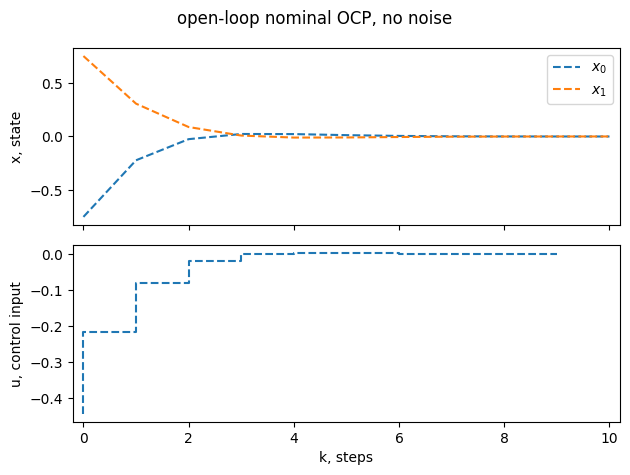

In [63]:
# plot u, x on same x-axis (steps)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# X
for j in range(X_soln.shape[0]):
    ax1.plot(X_soln[j, :], '--', label=f'$x_{j}$')
if j > 0:
    ax1.legend()
ax1.set_ylabel('x, state')

# U --> step() as this is your controller knob
for i in range(U_soln.shape[0]):
    ax2.step(U_soln[i, :], '--', label=f'$u_{i}$')
if i > 0:
    ax2.legend()
ax2.set_ylabel('u, control input')
fig.suptitle('open-loop nominal OCP, no noise')
ax2.set_xlabel('k, steps')
ax1.set_xlim(-0.2, 10.2)
plt.tight_layout()

Noise

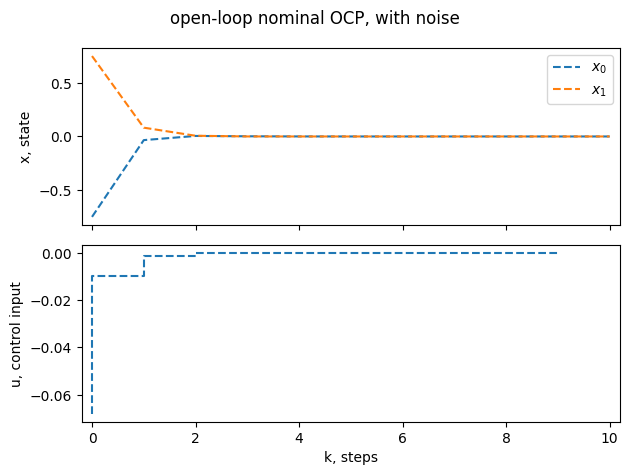

In [64]:
# plot u, x on same x-axis (steps)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# X
for j in range(noise_X_soln.shape[0]):
    ax1.plot(noise_X_soln[j, :], '--', label=f'$x_{j}$')
if j > 0:
    ax1.legend()
ax1.set_ylabel('x, state')

# U --> step() as this is your controller knob
for i in range(noise_U_soln.shape[0]):
    ax2.step(noise_U_soln[i, :], '--', label=f'$u_{i}$')
if i > 0:
    ax2.legend()
ax2.set_ylabel('u, control input')
fig.suptitle('open-loop nominal OCP, with noise')
ax2.set_xlabel('k, steps')
ax1.set_xlim(-0.2, 10.2)
plt.tight_layout()

#### Closed-loop construction

In [65]:
sim_hori = 50 # simulation horizon

In [66]:
# Extract array --> reshape to column --> Transpose
U_soln = np.array([soln.value(u) for u in U]).reshape(-1, u_controls).T
X_soln = np.array([soln.value(x) for x in X]).reshape(-1, x_states).T
Y_soln = np.array([soln.value(y) for y in Y]).reshape(-1, y_outputs).T

In [76]:
noise_U_soln = np.array([soln.value(u) for u in noise_U]).reshape(-1, u_controls).T
noise_X_soln = np.array([soln.value(x) for x in noise_X]).reshape(-1, x_states).T
noise_Y_soln = np.array([soln.value(y) for y in noise_Y]).reshape(-1, y_outputs).T

In [68]:
# defining containers
Xsim = np.zeros((x_states, sim_hori + 1)) # state evolution
Ysim = np.zeros((y_outputs, sim_hori + 1)) # output evolution
Usim = np.zeros((u_controls, sim_hori)) # input evolution
Jsim = np.zeros((1, sim_hori)) # cost evolution

In [69]:
Xsim[:,0] = np.ravel(initial_state) # set the initial state
Ysim[:,0] = np.ravel(g(Xsim[:,0]).full())

Noise

In [77]:
# defining containers
noise_Xsim = np.zeros((x_states, sim_hori + 1)) # state evolution
noise_Ysim = np.zeros((y_outputs, sim_hori + 1)) # output evolution
noise_Usim = np.zeros((u_controls, sim_hori)) # input evolution
noise_Jsim = np.zeros((1, sim_hori)) # cost evolution

noise_Xsim[:,0] = np.ravel(initial_state) # set the initial state
noise_Ysim[:,0] = np.ravel(g(Xsim[:,0]).full())

##### Closed-loop solve

In [71]:
for k in range(sim_hori):
    opti.set_value(X[0], Xsim[:, k])
    sol = opti.solve()
    U_soln = np.array([sol.value(u) for u in U]).reshape(u_controls, -1)
    Y_soln = np.array([sol.value(y) for y in Y]).reshape(u_controls, -1)
    Usim[:, k] = U_soln[:, 0] # only interested in first optimal input in control

    Xsim[:, k + 1] = np.ravel(f(Xsim[:, k], Usim[:, k]).full()) # apply input to plant
    Ysim[:, k + 1] = np.ravel(g(Xsim[:, k + 1]).full())

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.96ms (  2.42us)   2.62ms (  2.14us)      1224
       nlp_g  |   5.72ms (  4.67us)   4.61ms (  3.77us)      1224
    nlp_grad  |   1.12ms (  5.51us)   1.07ms (  5.25us)       203
  nlp_grad_f  |   4.06ms (  2.85us)   3.64ms (  2.55us)      1428
  nlp_hess_l  |   2.35ms (  2.30us)   2.12ms (  2.08us)      1020
   nlp_jac_g  |   5.45ms (  3.82us)   5.06ms (  3.54us)      1428
       total  |   6.36ms (  6.36ms)   6.33ms (  6.33ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.98ms (  2.42us)   2.64ms (  2.14us)      1230
       nlp_g  |   5.79ms (  4.71us)   4.67ms (  3.79us)      1230
    nlp_grad  |   1.12ms (  5.51us)   1.07ms (  5.25us)       204
  nlp_grad_f  |   4.09ms (  2.85us)   3.67ms (  2.56us)      1435
  nlp_hess_l  |   2.36ms (  2.30us)   2.13ms (  2.08us)      1025
   nlp_jac_g  |   5.49ms (  3.82us)   5.10ms (  3.55us)      1435
       tot

In [79]:
for k in range(sim_hori):
    opti.set_value(noise_X[0], noise_Xsim[:, k])
    sol = opti.solve()
    noise_U_soln = np.array([sol.value(u) for u in noise_U]).reshape(u_controls, -1)
    noise_Y_soln = np.array([sol.value(y) for y in noise_Y]).reshape(u_controls, -1)
    
    noise_Usim[:, k] = noise_U_soln[:, 0] # only interested in first optimal input in control

    noise_Xsim[:, k + 1] = np.ravel(f_noise(noise_Xsim[:, k], noise_Usim[:, k]).full()) # apply input to plant
    noise_Ysim[:, k + 1] = np.ravel(g(noise_Xsim[:, k + 1]).full())

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.43ms (  2.49us)   3.88ms (  2.19us)      1776
       nlp_g  |   7.82ms (  4.40us)   6.55ms (  3.69us)      1776
    nlp_grad  |   1.66ms (  5.48us)   1.60ms (  5.27us)       303
  nlp_grad_f  |   5.74ms (  2.76us)   5.28ms (  2.54us)      2080
  nlp_hess_l  |   3.34ms (  2.27us)   3.04ms (  2.07us)      1472
   nlp_jac_g  |   7.78ms (  3.74us)   7.32ms (  3.52us)      2080
       total  |   6.23ms (  6.23ms)   6.16ms (  6.16ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.44ms (  2.49us)   3.91ms (  2.20us)      1781
       nlp_g  |   7.85ms (  4.41us)   6.58ms (  3.70us)      1781
    nlp_grad  |   1.67ms (  5.48us)   1.60ms (  5.27us)       304
  nlp_grad_f  |   5.76ms (  2.76us)   5.29ms (  2.54us)      2086
  nlp_hess_l  |   3.35ms (  2.27us)   3.05ms (  2.07us)      1476
   nlp_jac_g  |   7.80ms (  3.74us)   7.35ms (  3.52us)      2086
       tot

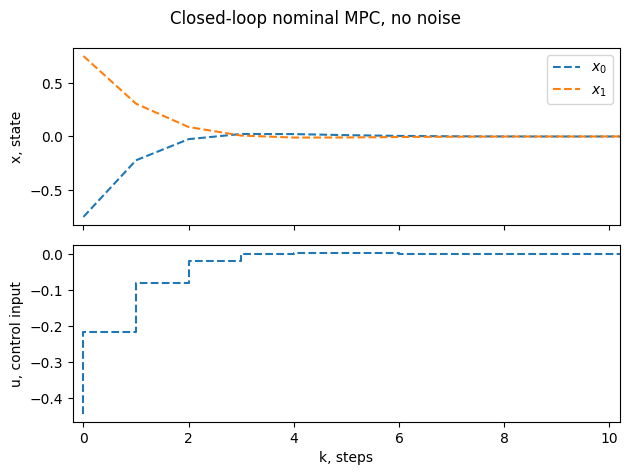

In [80]:
# plot u, x on same x-axis (steps)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# X
for i in range(Xsim.shape[0]):
    ax1.plot(Xsim[i, :], '--', label=f'$x_{i}$')
ax1.legend()
ax1.set_ylabel('x, state')

# U --> step() as this is your controller knob
ax2.step(np.arange(Usim.shape[1]),np.ravel(Usim), '--') 
ax2.set_ylabel('u, control input')

ax2.set_xlabel('k, steps')
fig.suptitle('Closed-loop nominal MPC, no noise')
ax1.set_xlim(-0.2, 10.2)
plt.tight_layout()

In [81]:
noise_Usim

array([[-6.79827772e-02, -9.68600951e-03, -1.14710776e-03,
        -1.07759833e-04, -6.04725237e-06,  4.06144761e-07,
         2.00989446e-07,  4.10637218e-08,  6.36188163e-09,
         8.15087861e-10,  8.55151131e-11,  6.43514181e-12,
         6.87991982e-14, -9.41288021e-14, -2.36817361e-14,
        -4.04323884e-15, -5.59534969e-16, -6.42712048e-17,
        -5.74833725e-18, -2.69662700e-19,  3.43152392e-20,
         1.28359229e-20,  2.47853345e-21,  3.71885637e-22,
         4.63035036e-23,  4.67786714e-24,  3.22524309e-25,
        -3.28605906e-27, -6.32734088e-27, -1.45595817e-27,
        -2.39295611e-28, -3.21812807e-29, -3.58050734e-30,
        -3.02882347e-31, -1.08746600e-32,  2.60500532e-33,
         8.09530712e-34,  1.48740499e-34,  2.16433695e-35,
         2.61762608e-36,  2.53796175e-37,  1.56866208e-38,
        -6.11365539e-40, -4.15674772e-40, -8.88536041e-41,
        -1.40961811e-41, -1.84264988e-42, -1.98235843e-43,
        -1.57223279e-44, -3.51852401e-46]])

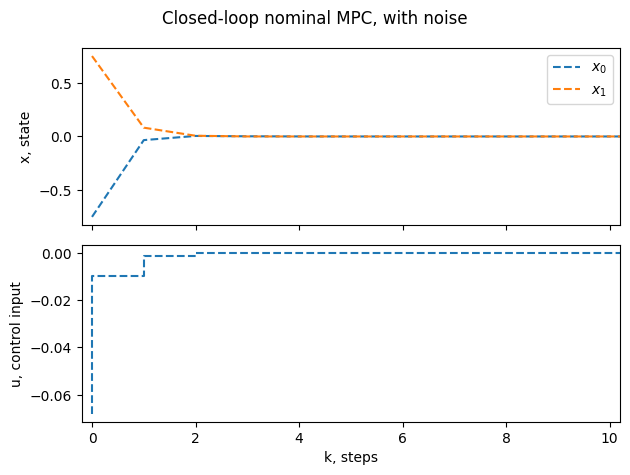

In [82]:
# plot u, x on same x-axis (steps)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# X
for i in range(noise_Xsim.shape[0]):
    ax1.plot(noise_Xsim[i, :], '--', label=f'$x_{i}$')
ax1.legend()
ax1.set_ylabel('x, state')

# U --> step() as this is your controller knob
ax2.step(np.arange(noise_Usim.shape[1]),np.ravel(noise_Usim), '--') 
ax2.set_ylabel('u, control input')

ax2.set_xlabel('k, steps')
fig.suptitle('Closed-loop nominal MPC, with noise')
ax1.set_xlim(-0.2, 10.2)
plt.tight_layout()